# 1. 시계열 데이터 준비

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-03-02    55000.0
2020-03-03    55400.0
2020-03-04    57400.0
2020-03-05    57800.0
2020-03-06    56500.0
Name: Close, dtype: float64

# 2. 각종 전처리 수행

In [2]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [3]:
ts_log = np.log(ts)

# 3. 시계열 안정성 분석

In [4]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [5]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  
    rolstd = timeseries.rolling(window=window).std()

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [6]:
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

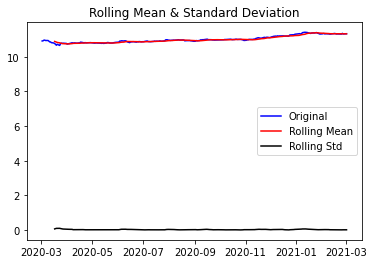

Results of Dickey-Fuller Test:
Test Statistic                  -0.079728
p-value                          0.951421
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


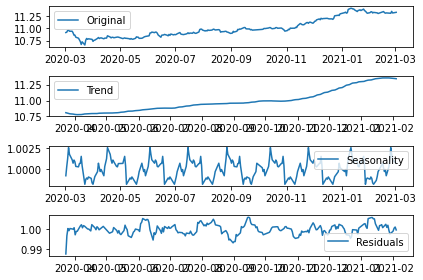

In [7]:
plot_rolling_statistics(ts_log, window=12)

augmented_dickey_fuller_test(ts_log)

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [8]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.608998e+00
p-value                        6.447826e-09
#Lags Used                     0.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


# 4. 학습, 테스트 데이터셋 생성

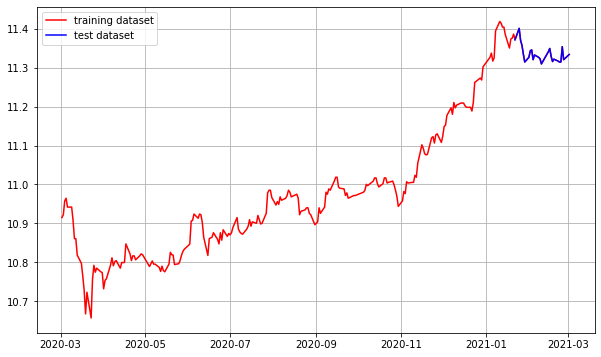

In [9]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 5. 적정 ARIMA 모수 찾기

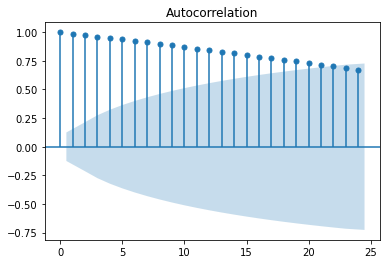

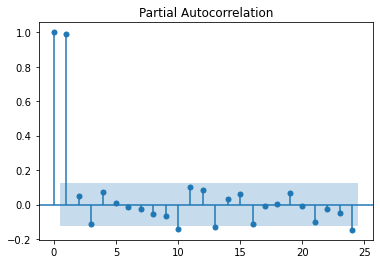

In [10]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.622497e+01
p-value                        3.863400e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.000856e+00
p-value                        7.328463e-10
#Lags Used                     1.500000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


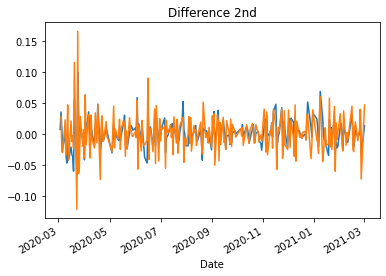

In [11]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 6. ARIMA 모델 훈련과 테스트

In [12]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 535.182
Method:                       css-mle   S.D. of innovations              0.021
Date:                Tue, 02 Mar 2021   AIC                          -1064.365
Time:                        22:37:39   BIC                          -1054.170
Sample:                             1   HQIC                         -1060.248
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0021      0.001      1.505      0.132      -0.001       0.005
ar.L1.D.Close    -0.0210      0.067     -0.313      0.755      -0.153       0.111
                                    Root

/home/ssac/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided

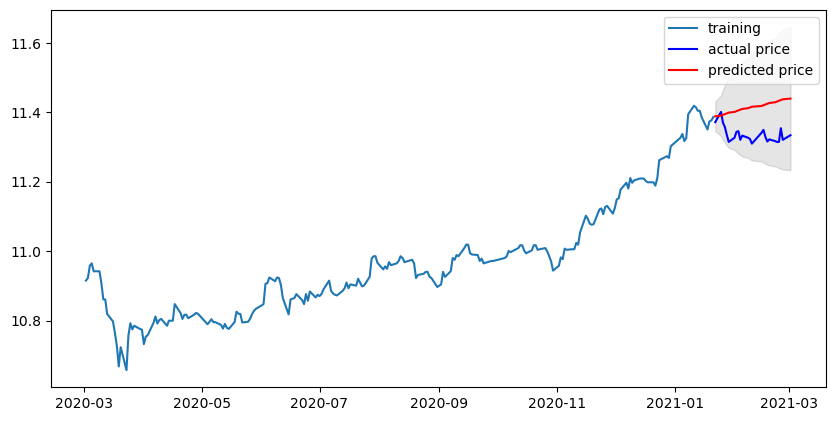

In [13]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [14]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  54474479.26595905
MAE:  6880.912674502514
RMSE:  7380.682845506847
MAPE: 8.28%


# 7. 다른 주식 종목 예측해 보기

# Disney

In [15]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/DIS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-03-02    119.980003
2020-03-03    116.449997
2020-03-04    119.180000
2020-03-05    113.980003
2020-03-06    115.269997
Name: Close, dtype: float64

In [16]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [17]:
ts_log = np.log(ts)

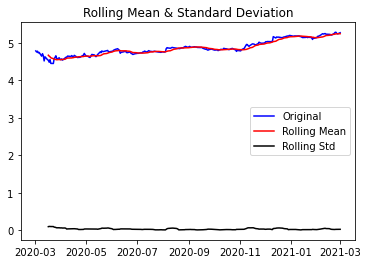

Results of Dickey-Fuller Test:
Test Statistic                   0.194018
p-value                          0.971924
#Lags Used                       6.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


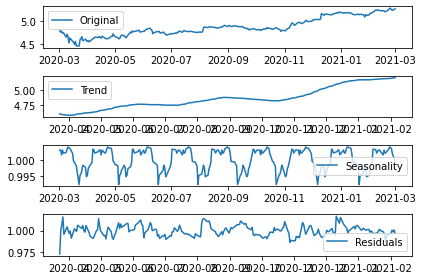

In [18]:
plot_rolling_statistics(ts_log, window=12)

augmented_dickey_fuller_test(ts_log)

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [19]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.478343e+00
p-value                        1.313931e-08
#Lags Used                     2.000000e+00
Number of Observations Used    2.190000e+02
Critical Value (1%)           -3.460567e+00
Critical Value (5%)           -2.874830e+00
Critical Value (10%)          -2.573853e+00
dtype: float64


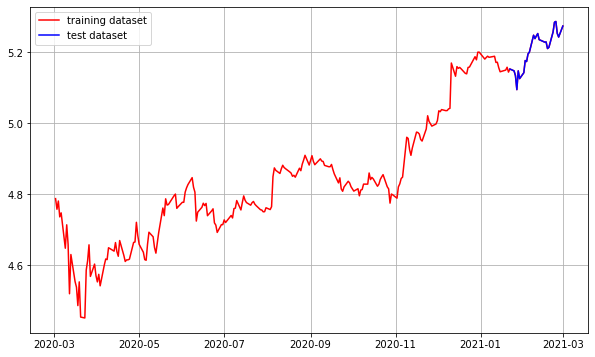

In [20]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

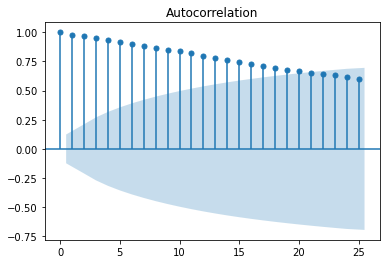

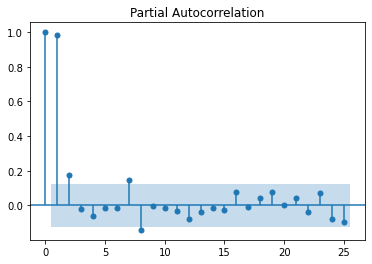

In [21]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.515627e+00
p-value                        3.910314e-11
#Lags Used                     5.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -8.105354e+00
p-value                        1.267209e-12
#Lags Used                     1.100000e+01
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64


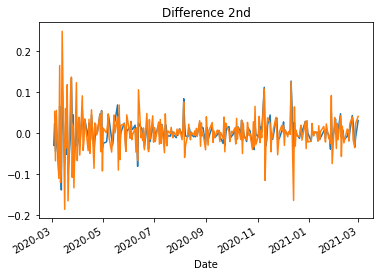

In [22]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [23]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 463.852
Method:                       css-mle   S.D. of innovations              0.031
Date:                Tue, 02 Mar 2021   AIC                           -921.704
Time:                        22:37:41   BIC                           -911.456
Sample:                             1   HQIC                          -917.568
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0016      0.002      0.969      0.333      -0.002       0.005
ar.L1.D.Close    -0.2280      0.065     -3.511      0.000      -0.355      -0.101
                                    Root

/home/ssac/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided

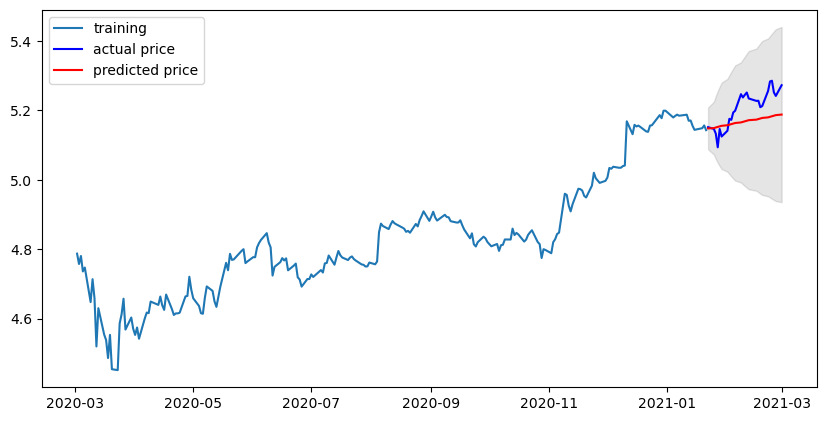

In [24]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [25]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  109.94184925640099
MAE:  8.860499112936319
RMSE:  10.48531588729691
MAPE: 4.73%


# APPLE

In [26]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-03-02    74.702499
2020-03-03    72.330002
2020-03-04    75.684998
2020-03-05    73.230003
2020-03-06    72.257500
Name: Close, dtype: float64

In [27]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [28]:
ts_log = np.log(ts)

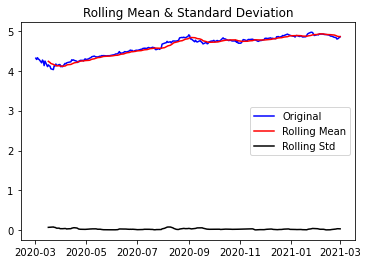

Results of Dickey-Fuller Test:
Test Statistic                  -1.125847
p-value                          0.704655
#Lags Used                       6.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


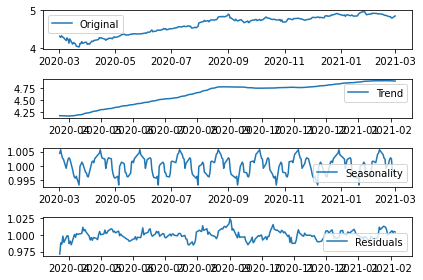

In [29]:
plot_rolling_statistics(ts_log, window=12)

augmented_dickey_fuller_test(ts_log)

decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [30]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.450609e+00
p-value                        1.526839e-08
#Lags Used                     0.000000e+00
Number of Observations Used    2.210000e+02
Critical Value (1%)           -3.460291e+00
Critical Value (5%)           -2.874709e+00
Critical Value (10%)          -2.573789e+00
dtype: float64


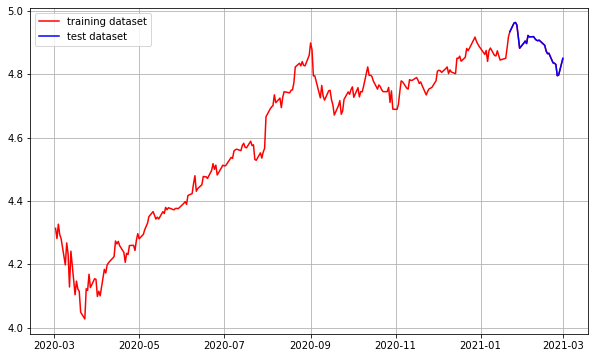

In [31]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

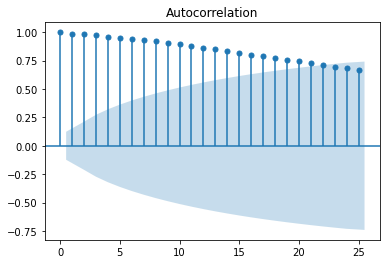

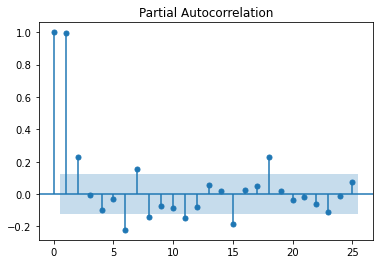

In [32]:
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -20.422473
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.042683e+01
p-value                        1.649364e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


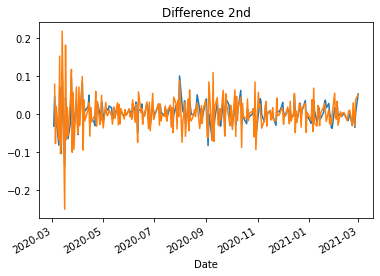

In [33]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [34]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 481.584
Method:                       css-mle   S.D. of innovations              0.028
Date:                Tue, 02 Mar 2021   AIC                           -957.168
Time:                        22:37:42   BIC                           -946.920
Sample:                             1   HQIC                          -953.032
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0027      0.001      1.823      0.068      -0.000       0.006
ar.L1.D.Close    -0.2853      0.064     -4.449      0.000      -0.411      -0.160
                                    Root

/home/ssac/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ssac/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided

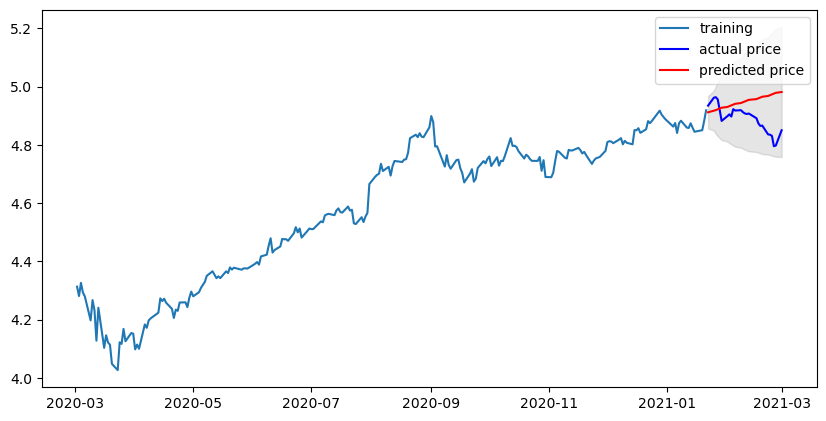

In [35]:
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [36]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  132.40870783774614
MAE:  9.276149668727701
RMSE:  11.506898271808357
MAPE: 7.19%


# 결과

삼성: 8.28%   
디즈니: 4.73%   
애플: 7.19%   